In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
train_data_path = 'animal-10/train/'
test_data_path = 'animal-10/val/'
BATCH_SIZE = 32
EPOCH = 300
INPUT_SIZE = 256

train_transform = transforms.Compose(
    [transforms.RandomResizedCrop((INPUT_SIZE,INPUT_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(
    root = train_data_path,
    transform = train_transform
    )
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

val_transform = transforms.Compose(
    [transforms.Resize((INPUT_SIZE,INPUT_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_data = torchvision.datasets.ImageFolder(
    root = train_data_path,
    transform = val_transform
    )
valloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_transform = transforms.Compose(
    [transforms.Resize((INPUT_SIZE,INPUT_SIZE)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = torchvision.datasets.ImageFolder(
    root = test_data_path,
    transform = test_transform
    )
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('butterfly', 'cat', 'chicken', 'cow', 'dog',
    'elephant', 'horse', 'sheep', 'spider', 'squirrel')

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

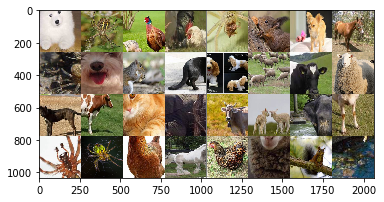

       dog     spider    chicken    chicken     spider   squirrel        dog      horse     spider        dog   squirrel        cat        dog      sheep        cow      sheep        dog        cow        cat   elephant        cow      sheep   elephant      sheep     spider     spider    chicken      horse    chicken      sheep   squirrel   squirrel


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(BATCH_SIZE)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, padding = 3)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 5, padding = 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, padding = 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x): #3, 256, 256
        x = F.relu(self.conv1(x)) #6, 256, 256
        x = self.pool1(x) #6, 64, 64 
        x = F.relu(self.conv2(x)) #16, 64, 64
        x = self.pool2(x) #16, 32, 32
        x = F.relu(self.conv3(x)) #32, 32, 32
        x = self.pool3(x) #32, 16, 16
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net()
if torch.cuda.is_available():
    net = net.cuda()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [8]:
def validation_data_accuracy():
    #Accuracy for training data
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [9]:
def test_data_accuracy():
    #Accuracy for testing data
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [10]:
loss_value = []
train_accuracy = []
test_accuracy = []

for epoch in range(EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    #Accuracy
    tr_acc = validation_data_accuracy()
    ts_acc = test_data_accuracy()
    ls = running_loss / len(trainloader)
    train_accuracy.append(tr_acc)
    test_accuracy.append(ts_acc)
    loss_value.append(ls)
    print('Epoch', epoch, 'with loss of', ls, 'training acc of', tr_acc, 'testing acc of', ts_acc)

print('Finished Training')

Epoch 0 with loss of 2.231767078558096 training acc of 23.0 testing acc of 22.775
Epoch 1 with loss of 2.046383507716389 training acc of 32.48 testing acc of 31.95
Epoch 2 with loss of 1.9702811953358756 training acc of 36.06 testing acc of 35.275
Epoch 3 with loss of 1.918878566723662 training acc of 38.34 testing acc of 38.45
Epoch 4 with loss of 1.8838501121289433 training acc of 40.46 testing acc of 40.0
Epoch 5 with loss of 1.8388765536177272 training acc of 41.55 testing acc of 41.575
Epoch 6 with loss of 1.7966859115960119 training acc of 43.23 testing acc of 42.8
Epoch 7 with loss of 1.7796045701724652 training acc of 44.09 testing acc of 43.575
Epoch 8 with loss of 1.7481908383079992 training acc of 45.04 testing acc of 43.8
Epoch 9 with loss of 1.705430954789963 training acc of 48.0 testing acc of 46.325
Epoch 10 with loss of 1.6850961774301987 training acc of 46.48 testing acc of 44.65
Epoch 11 with loss of 1.6588634111629887 training acc of 49.66 testing acc of 47.75
Epoch 

Epoch 98 with loss of 0.830967513612284 training acc of 88.64 testing acc of 62.175
Epoch 99 with loss of 0.8259315701148 training acc of 88.44 testing acc of 61.45
Epoch 100 with loss of 0.8295955142845362 training acc of 89.25 testing acc of 61.875
Epoch 101 with loss of 0.8237392544365538 training acc of 88.02 testing acc of 60.75
Epoch 102 with loss of 0.82580698612399 training acc of 86.66 testing acc of 59.525
Epoch 103 with loss of 0.8024950627320871 training acc of 88.05 testing acc of 61.025
Epoch 104 with loss of 0.8114573833660577 training acc of 88.19 testing acc of 60.65
Epoch 105 with loss of 0.7929469535525996 training acc of 89.22 testing acc of 61.95
Epoch 106 with loss of 0.8077093025746818 training acc of 88.35 testing acc of 60.825
Epoch 107 with loss of 0.7993318530888603 training acc of 88.94 testing acc of 60.725
Epoch 108 with loss of 0.7822110903339264 training acc of 89.21 testing acc of 60.825
Epoch 109 with loss of 0.7704091273938505 training acc of 89.4 tes

Epoch 195 with loss of 0.5460161701463663 training acc of 95.52 testing acc of 62.075
Epoch 196 with loss of 0.5396156974684316 training acc of 96.37 testing acc of 62.15
Epoch 197 with loss of 0.5237029184596226 training acc of 96.0 testing acc of 62.75
Epoch 198 with loss of 0.5417177943756786 training acc of 95.87 testing acc of 62.625
Epoch 199 with loss of 0.5368676586463429 training acc of 96.09 testing acc of 62.8
Epoch 200 with loss of 0.5703326720304002 training acc of 95.02 testing acc of 61.35
Epoch 201 with loss of 0.5515431229489299 training acc of 95.23 testing acc of 61.725
Epoch 202 with loss of 0.5507154032921258 training acc of 96.17 testing acc of 61.55
Epoch 203 with loss of 0.5266896170644334 training acc of 96.5 testing acc of 62.75
Epoch 204 with loss of 0.5444883711802693 training acc of 95.33 testing acc of 61.75
Epoch 205 with loss of 0.5384020594933543 training acc of 96.15 testing acc of 62.2
Epoch 206 with loss of 0.5278275655195735 training acc of 95.89 te

Epoch 291 with loss of 0.44305089396981007 training acc of 96.66 testing acc of 61.625
Epoch 292 with loss of 0.4375427383631944 training acc of 97.3 testing acc of 62.2
Epoch 293 with loss of 0.42047535816130166 training acc of 97.3 testing acc of 62.4
Epoch 294 with loss of 0.43179848271246535 training acc of 97.28 testing acc of 61.7
Epoch 295 with loss of 0.4463583884385828 training acc of 96.86 testing acc of 61.575
Epoch 296 with loss of 0.43150514278548974 training acc of 96.62 testing acc of 62.55
Epoch 297 with loss of 0.42243719434204957 training acc of 97.32 testing acc of 62.875
Epoch 298 with loss of 0.42232108875490226 training acc of 96.7 testing acc of 62.05
Epoch 299 with loss of 0.41831819532207026 training acc of 97.47 testing acc of 62.75
Finished Training


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of butterfly : 73 %
Accuracy of   cat : 51 %
Accuracy of chicken : 75 %
Accuracy of   cow : 50 %
Accuracy of   dog : 46 %
Accuracy of elephant : 75 %
Accuracy of horse : 68 %
Accuracy of sheep : 58 %
Accuracy of spider : 67 %
Accuracy of squirrel : 61 %


In [12]:
print('Loss value: ', loss_value[-1])
print('Training accuracy: ', train_accuracy[-1])
print('Testing accuracy: ', test_accuracy[-1])

Loss value:  0.41831819532207026
Training accuracy:  97.47
Testing accuracy:  62.75


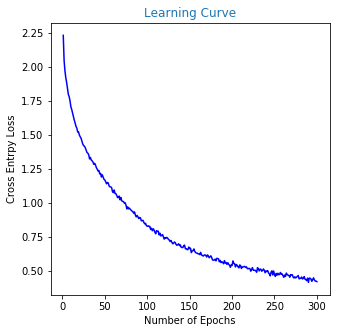

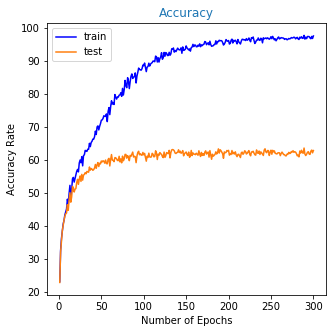

In [13]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Learning Curve'.format('default'), color='C0')
ax.set_ylabel('Cross Entrpy Loss')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(loss_value))), loss_value, 'b')

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Accuracy'.format('default'), color='C0')
ax.set_ylabel('Accuracy Rate')
ax.set_xlabel('Number of Epochs')
ax.plot(list(i+1 for i in range(len(train_accuracy))), train_accuracy, 'b', label='train')
ax.plot(list(i+1 for i in range(len(test_accuracy))), test_accuracy, 'tab:orange', label='test')
ax.legend()